# Module 2 Project Submission

* Student name: Miya Kusumoto
* Student pace: self paced
* Scheduled project review date/time: Friday, May 9, 2019; 12:00 pm CT
* Instructor name: Eli Thomas

## Introduction

As the Northwind Company begins planning marketing, people, growth, and tech strategies for 2020, this portfolio analysis should help business leaders understand the following about customers, employees, and sales strategies:
* Discounts have a significant and meaningful effect on the quantity of items purchased by customers, however pricing and timing are important considerations in making these decisions as well.
* Employees with longer tenure have marginal increases in sales YoY. While this may indicate that employees have more opportunity for growth earlier in their tenure, it could also indicate that employees with longer tenure have burnt out and that training and rewards programs could be revitalized. 
* The largest subset of customers is from this region.... ? 

In [115]:
##import statements
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import sqlalchemy
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import inspect
from sqlalchemy import MetaData
from sqlalchemy.ext.automap import automap_base

import sqlite3
import pandas as pd

from mpl_toolkits.basemap import Basemap

import scipy.stats as st
from scipy.stats import kurtosis
from scipy.stats import skew

import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score



# Part 1: Obtain, Scrub, Explore

We will begin by obtaining our dataset. The steps that we have to take to acquire our data include: 
* Utilize SQL Alchemy to connect to the Northwind DB
* Use SQLAlchemy Session Objects to map our database to python classes
* Create a DataFrame from the necessary tables so that we can clean it up and analyze

Because our data is stored in a database and we do not want to pull in every table every time, we will repeat parts of this process for each of test question we decide to answer. 

In [106]:
#Utilize sqlalchemy to connect to our db
engine = create_engine("sqlite:///Northwind_small.sqlite", echo=True)
Session = sessionmaker(bind=engine)
session = Session()

In [4]:
#use inspector to get table names and understand what information is included in the database.
inspector = inspect(engine)

print(inspector.get_table_names())

2019-05-04 08:09:51,125 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-05-04 08:09:51,126 INFO sqlalchemy.engine.base.Engine ()
2019-05-04 08:09:51,128 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-05-04 08:09:51,128 INFO sqlalchemy.engine.base.Engine ()
2019-05-04 08:09:51,130 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-05-04 08:09:51,131 INFO sqlalchemy.engine.base.Engine ()
['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']


### Table Names are: 
- Category
- Customer
- CustomerCustomerDemo
- CustomerDemographic
- Employee
- EmployeeTerritory
- Order
- OrderDetail
- Product
- Region
- Shipper
- Supplier
- Territory

Now that we have the table names, we can check with the ERD to ensure that everything checks out. We can see that there are quite a few discrepancies in our table names. 

Looks like table names in the ERD are plural where in our actual DB they are singular. We will have to keep an eye on that when we begin to work with the tables. 

It is good that we now have a list of the exact column names included in our database. We will rely heavily on this as we begin pulling together multiple tables to answer more complicated questions. 

In [5]:
#lets look at the columns and data types included in our OrderDetail table.
#For the initial question, this is what we will be focusing on. 

print(inspector.get_columns("OrderDetail"))

2019-05-04 08:09:51,147 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("OrderDetail")
2019-05-04 08:09:51,149 INFO sqlalchemy.engine.base.Engine ()
[{'name': 'Id', 'type': VARCHAR(length=8000), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}, {'name': 'OrderId', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'ProductId', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'UnitPrice', 'type': DECIMAL(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'Quantity', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'Discount', 'type': FLOAT(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}]


The current structure is messy; let's write a function that allows us to see the table names in a clean and well-organized manner. The structure of the output from our .get_columns function is a list of dictionaries. 

In [6]:
def get_columns_info(col_name):
    cols_list = inspector.get_columns(col_name)
    
    print("Table Name: {}".format(col_name))
    print("")
    
    for col in cols_list:
        print("Name: {} \t Type: {}".format(col['name'], col['type']))

get_columns_info('OrderDetail')

Table Name: OrderDetail

Name: Id 	 Type: VARCHAR(8000)
Name: OrderId 	 Type: INTEGER
Name: ProductId 	 Type: INTEGER
Name: UnitPrice 	 Type: DECIMAL
Name: Quantity 	 Type: INTEGER
Name: Discount 	 Type: FLOAT


Now that we are able to obtain basic information about all of the tables in the dataset, let's revisit the initial question. We do this because it is important to understand what information in what tables we will need to pull from our database.

### Revisit the Question: Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

To answer this first question, we will likely only need the Order Detail table. As we were able to see from our exploration above, that table includes the **OrderID**, the **ProductID**, the **Unit Price**, the **Quantity**, and the **Discount**. This should be the extent of the information that we need in order to answer our question. 

Now let's get this OrderDetail table into a Pandas DataFrame so that we can easily explore and analyze it to hopefully answer our question. 

In [7]:
#This SQL query selects all rows and columns from my OrderDetail table and puts it into a dataframe. 

q = """SELECT * from OrderDetail"""

df1 = pd.read_sql_query(q, engine)
df1.head()

2019-05-04 08:09:51,176 INFO sqlalchemy.engine.base.Engine SELECT * from OrderDetail
2019-05-04 08:09:51,178 INFO sqlalchemy.engine.base.Engine ()


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [8]:
#what datatypes are each of my columns? I want to make sure they are casted correctly
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


Above, we see that most of our columns are cast correctly. THe only two that I would like to change are the **OrderID** and **ProductID**. In this case I would like to keep them categorical so I will convert them to strings.

In [9]:
df1["OrderId"] = df1["OrderId"].astype("str")
df1["ProductId"] = df1["ProductId"].astype("str")

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null object
ProductId    2155 non-null object
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 101.1+ KB


It appears that all my columns are the correct type and there are no missing values in any of the columns. Before we begin hypothesis testing, let's try to get a better understanding of what exactly is in each of the columns. Below I will describe the dataframe to see the mean, median, max, min, and standard deviation of my continuous variables. 

In [10]:
df1.describe()

,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000
mean,26.218520,23.812993,0.056167
std,29.827418,19.022047,0.083450
min,2.000000,1.000000,0.000000
25%,12.000000,10.000000,0.000000
50%,18.400000,20.000000,0.000000
75%,32.000000,30.000000,0.100000
max,263.500000,130.000000,0.250000


In [11]:
print(len(df1["Discount"].unique()))
print(df1["Discount"].unique())

11
[0.   0.15 0.05 0.2  0.25 0.1  0.02 0.03 0.04 0.06 0.01]


<Figure size 1440x1440 with 0 Axes>

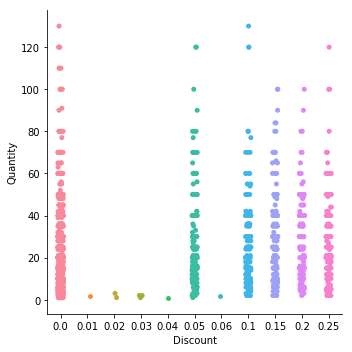

In [12]:
plt.figure(figsize = (20, 20))
sns.catplot(x="Discount", y="Quantity", jitter = True, data=df1);

In my description table, it doesn't appear that there are any outliers but the minimum price is \\$2 and the maximum price is \\$263.50. The majority of our products seem to be priced much lower in the \\$12 - \\$18 range. 

Quantities look pretty standard where most orders contain product quantities between 10 and 30 units. 

The Discount is more interesting and harder to understand based on the initial Describe output. To get insight into what discounts are present in the orders, I will check the unique values. There are 11 different discount percentages ranging from **0% (no discount) to 25%**. From the looks of my small visualization to better explain this, it appears that the majority of discounts fall in the **0%**, **5%**, **10%**, **15%**, **20%**, and **25%** buckets. 

To begin our hypothesis testing, we first need to see the distribution of the data so we know if our data is normally distributed.

/Users/miyakusumoto/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 0, 'Quantity of Product Ordered')

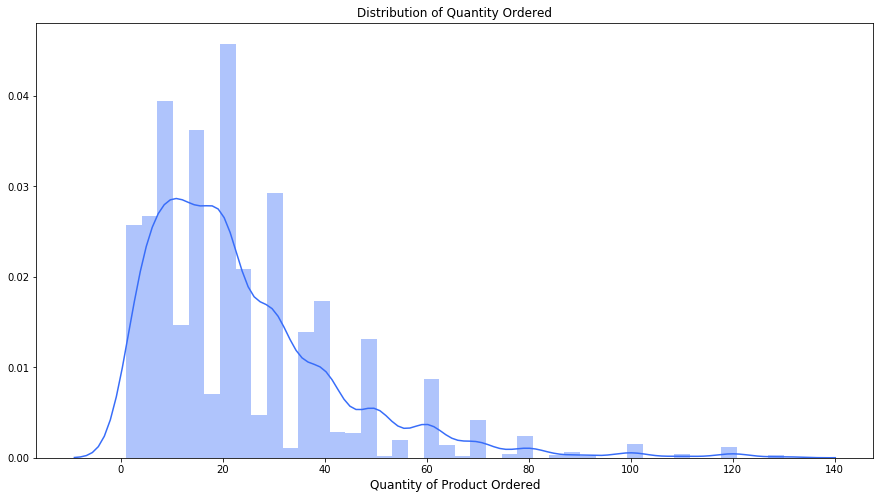

In [13]:
#visualize the distribution of the Quantity column
sns.set_palette('rainbow')

plt.figure(figsize=(15, 8))
sns.distplot(df1['Quantity']);
plt.title('Distribution of Quantity Ordered', fontsize=12)
plt.xlabel('Quantity of Product Ordered', fontsize=12)

The quantity of products ordered appears to be skewed to the right with varying quantities in between. Because it is not normally distributed, we will need to use the **Central Limit Theorem** to create a sample distribution of sample means that will be normally distributed so that we can utilize p-values and z-scores to answer our question. 

# Part 2: Experimental Design (Modeling + Interpreting)

Sound experimental design underpins every decision we make as a data scientist. To ensure my problem and experiment are set up properly, a few things will happen in this phase: 
 - **Control Group will be defined**: Our control group is the group that allows us to compare outcomes. In this case our control group will include orders with **no** discount. The control group is important because without it we would have no insight into how much of our results can be attributed to the discount. 
 - **Appropriate Sample Size**: Large sample sizes protect us from randomness and variance. 
 - **Reproducibility**: In this situation we won't have to focus on this too much, but we do want to ensure that this experiment has Reproducible Results. 

### Revisit the Question
Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

### Definining the Hypothesis


**Null Hypothesis ($H_O: \mu1 <= \mu_2$)**: The treatment group with a discount will not purchase larger quantities of a product in an order.

**Alternative Hypothesis ($H_a: \mu_1 > \mu_2$)**: The treatment group with a discount will purchase larger quantities of products in an order.

In this experiment I will be conducting a **_One-Tail Test_** because I want to know if the quantity of products in an order from the treatment group (orders **_with_** discount) is greater than the quantity of products per order from our control group (orders **_without_** discount). 

In this experiment we will also be dealing with **_Discrete_** data because the quantity of products in each order are integers. You can not buy half of a product. 

With this in mind, we know we conducting an **Upper/Right-Tailed** test.

### Test our Hypothesis: 
1. Divide our data into two groups: the **treatment group** and the **contol group**.
2. Check for **normality**. If our data is not normal (which we know from above, we will need to create a normal sample distribution.
3. Caluculate a few sample statistics: 
 - The population mean (μ).
 - The sample mean (x̄). Calculate from the sample data
 - The sample standard deviation (sigma). Calculate from sample data
 - Number of observations(n). Calculated from the sample data.
 - Degrees of Freedom(df). Calculate from the sample as df = total no. of observations - 1
4. Calcluate the **t-value** (because at this point we will know our normality, independence, and randomness requirements are satisfied)
5. Find the **Critical T-Value**
6. Compare t-values to accept or reject the Null Hypothesis ($H_O$)
7. Check for Type 1 and Type 2 Errors (and ensure a 95% confidence level is correct)




### 1. Treatment Group and Control Group
To be able to run our experiment, we need to divide our data into the treatment and control groups. 
 - The **Control Group** includes all item/quantity pairs where **_no_** discount was received
 - The **Treatment Group** is exactly the opposite and includes all item/quantity pairs where **_any_** discount was received. 

In [14]:
#Create my control and treatment groups by dividing up my dataframe
control = df1[df1['Discount'] == 0]
control = control['Quantity']
treatment = df1[df1['Discount'] != 0]
treatment = treatment['Quantity']

### Normality 
Before we can make use of the normal distribution, we need to first confirm that our data is normally distributed. If it is not, then we'll need to use the Central Limit Theorem to create a sample distribution of sample means that will be normally distributed.

There are two main ways to check if a sample follows the normal distribution or not. The easiest is to simply plot the data and visually check if the data follows a normal curve or not.

/Users/miyakusumoto/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


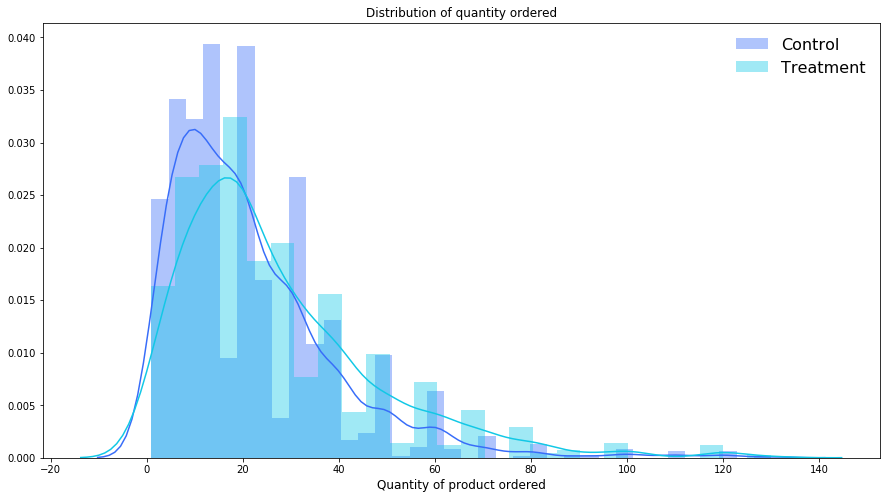

In [15]:
#First I will check normality visually
plt.figure(figsize=(15, 8))
sns.distplot(control, label='Control')
sns.distplot(treatment, label='Treatment')
plt.title('Distribution of quantity ordered', fontsize=12)
plt.xlabel('Quantity of product ordered', fontsize=12)
plt.legend(frameon=False, fontsize=16, loc='best')

In [16]:
#check normality using scipy normaltest function
print("Control:", st.normaltest(control))
print("Treatment:", st.normaltest(treatment))

Control: NormaltestResult(statistic=544.5770045551502, pvalue=5.579637380545965e-119)
Treatment: NormaltestResult(statistic=261.528012299789, pvalue=1.6214878452829618e-57)


Given the obvious visual cues that our data is not normal paired with our very low p-values for each group, we know that our data is not normally distributed. 

With that in mind, we'll need to use the Central Limit Theorem.

### Sampling with Replacement
In order to create a Sample Distribution of Sample Means, we need to first write a function that can sample with replacement.

The cell below returns a random sample of our data. 

In [17]:
def get_sample(data, n):
    sample = []
    while len(sample) != n:
        x = np.random.choice(data)
        sample.append(x)
    
    return sample

def get_sample_mean(sample):
    return sum(sample) / len(sample)

def create_sample_distribution(data, dist_size=1000, n=500):
    sample_dist = []
    while len(sample_dist) != dist_size:
        sample = get_sample(data, n)
        sample_mean = get_sample_mean(sample)
        sample_dist.append(sample_mean)
    
    return sample_dist

In [18]:
#create sample distributions
ctrl_sample = create_sample_distribution(control)
tmt_sample = create_sample_distribution(treatment)

/Users/miyakusumoto/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


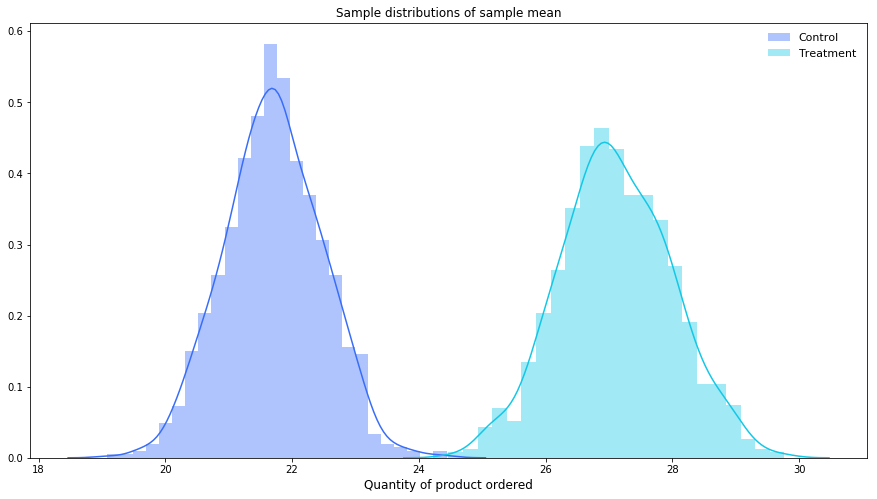

In [19]:
#Check and see if it worked!
plt.figure(figsize = (15, 8))
sns.distplot(ctrl_sample, label='Control')
sns.distplot(tmt_sample, label='Treatment')
plt.title('Sample distributions of sample mean', fontsize=12)
plt.xlabel('Quantity of product ordered', fontsize=12)
plt.legend(frameon=False, fontsize=11, loc='best')

This visualization of our normalized data makes it much more simple to see how a discount affects the quantity of product ordered. Let's run our T-Test to see if this is statistically significant.

In [20]:
#calculating test statistics

#population mean
mu = control.mean()
print("mu: ", mu)

#sample mean
x_bar = treatment.mean()
print("x-bar: ", x_bar)

#sigma
sigma = np.std(treatment, ddof=1)
print("standard deviation: ", sigma)

#Sample Size (n)
n = len(treatment)
print("n: ", n)

#difference in sample mean
diff = x_bar - mu

#calculate T-value
t = (x_bar -  mu)/(sigma/np.sqrt(n))
print("t: ", t)

mu:  21.715261958997722
x-bar:  27.10978520286396
standard deviation:  20.77143923484604
n:  838
t:  7.518106760070799


A positive t value indicates that the sample mean is greater than the population mean. This means that the sample's average sales performance with a discount is greater than average population sales performance. But is it statistically significant? Let's calculate the critical t-value.

In [21]:
# Calculate critical t value
t_crit = np.round(stats.t.ppf(1 - 0.05, df=837),3)
t_crit

1.647

With a critical t-value of 1.647 we can safely say (with 95% confidence) that a discount positively affects the quantity purchased. Now I want to understand what discount level causes a statistically significant effect. 

### Which discount levels have the largest effect?  
I will begin by testing each of my individual discount levels (5%, 10%, 15%, 20%, 25%). I will do this in a similar way as my general experiment: 
1. Divide our data into two groups: the **treatment group** and the **contol group**.
2. Check for **normality**. If our data is not normal (which we know from above, we will need to create a normal sample distribution.
3. Caluculate a few sample statistics: 
 - The population mean (μ).
 - The sample mean (x̄). Calculate from the sample data
 - The sample standard deviation (sigma). Calculate from sample data
 - Number of observations(n). Calculated from the sample data.
 - Degrees of Freedom(df). Calculate from the sample as df = total no. of observations - 1
4. Calcluate the **t-value** (because at this point we will know our normality, independence, and randomness requirements are satisfied)
5. Find the **Critical T-Value**
6. Compare t-values to accept or reject the Null Hypothesis ($H_O$)
7. Check for Type 1 and Type 2 Errors (and ensure a 95% confidence level is correct)

In [48]:
treatment5 = df1[(df1['Discount'] >= .045)&(df1['Discount'] <= .055)] 
treatment5 = treatment5['Quantity']

treatment10 = df1[(df1['Discount'] >= .095)&(df1['Discount'] <= .105)] 
treatment10 = treatment10['Quantity']

treatment15 = df1[(df1['Discount'] >= .145)&(df1['Discount'] <= .155)] 
treatment15 = treatment15['Quantity']

treatment20 = df1[(df1['Discount'] >= .195)&(df1['Discount'] <= .205)] 
treatment20 = treatment20['Quantity']

treatment25 = df1[(df1['Discount'] >= .245)&(df1['Discount'] <= .255)] 
treatment25 = treatment25['Quantity']

discounts= ["treatment5","treatment10","treatment15","treatment20","treatment25"]

/Users/miyakusumoto/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 0, 'Quantity of product ordered')

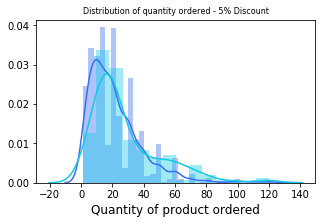

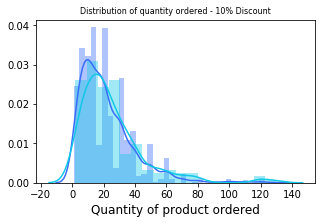

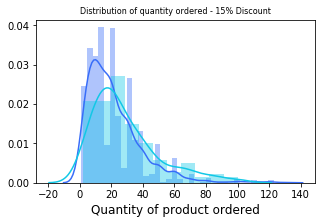

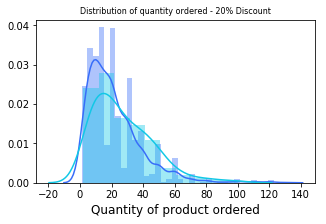

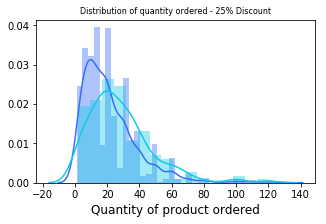

In [47]:
#First I will check normality visually

#Treatment at 5%
plt.figure(figsize = (5, 3))
sns.distplot(control, label='Control')
sns.distplot(treatment5, label="Treatment at 5% Discount")
plt.title('Distribution of quantity ordered - 5% Discount', fontsize=8)
plt.xlabel('Quantity of product ordered', fontsize=12)

#Treatment at 10%
plt.figure(figsize = (5, 3))
sns.distplot(control, label='Control')
sns.distplot(treatment10, label="Treatment at 10% Discount")
plt.title('Distribution of quantity ordered - 10% Discount', fontsize=8)
plt.xlabel('Quantity of product ordered', fontsize=12)

#Treatment at 15%
plt.figure(figsize = (5, 3))
sns.distplot(control, label='Control')
sns.distplot(treatment15, label="Treatment at 15% Discount")
plt.title('Distribution of quantity ordered - 15% Discount', fontsize=8)
plt.xlabel('Quantity of product ordered', fontsize=12)

#Treatment at 20%
plt.figure(figsize = (5, 3))
sns.distplot(control, label='Control')
sns.distplot(treatment20, label="Treatment at 20% Discount")
plt.title('Distribution of quantity ordered - 20% Discount', fontsize=8)
plt.xlabel('Quantity of product ordered', fontsize=12)

#Treatment at 25%
plt.figure(figsize = (5, 3))
sns.distplot(control, label='Control')
sns.distplot(treatment25, label="Treatment at 25% Discount")
plt.title('Distribution of quantity ordered - 25% Discount', fontsize=8)
plt.xlabel('Quantity of product ordered', fontsize=12)


In [56]:
#create sample distributions

ctrl_sample = create_sample_distribution(control)
tmt5_sample = create_sample_distribution(treatment5)
tmt10_sample = create_sample_distribution(treatment10)
tmt15_sample = create_sample_distribution(treatment15)
tmt20_sample = create_sample_distribution(treatment20)
tmt25_sample = create_sample_distribution(treatment25)


In [71]:
def one_sample_ttest(sample, popmean, alpha):

    # Visualize sample distribution for normality 
    sns.set(color_codes=True)
    sns.set(rc={'figure.figsize':(12,10)})
    sns.distplot(sample)
    
    # Populaqtion mean 
    mu = popmean
    
    # Sample mean (x̄) using NumPy mean()
    x_bar= sample.mean()

    # Sample Stadrad Deviation (sigma) using Numpy
    sigma = np.std(sample)
    
    # Degrees of freedom
    df = len(sample) - 1
    
    #Calculate the critical t-value
    t_crit = stats.t.ppf(1 - alpha, df=df)
    
    #Calculate the t-value and p-value
    results = stats.ttest_1samp(a= sample, popmean= mu)         
    
    if (results[0]>t_crit) and (results[1]<alpha):
        print ("Null hypothesis rejected. Results are statistically significant with t-value =", 
                round(results[0], 2), "critical t-value =", t_crit, "and p-value =", np.round((results[1]), 10))
    else:
        print ("Null hypothesis is True with t-value =", 
                round(results[0], 2), ", critical t-value =", t_crit, "and p-value =", np.round((results[1]), 10))

/Users/miyakusumoto/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Null hypothesis rejected. Results are statistically significant with t-value = 202.56 critical t-value = 1.646380345427535 and p-value = 0.0
Null hypothesis rejected. Results are statistically significant with t-value = 114.62 critical t-value = 1.646380345427535 and p-value = 0.0
Null hypothesis rejected. Results are statistically significant with t-value = 221.94 critical t-value = 1.646380345427535 and p-value = 0.0
Null hypothesis rejected. Results are statistically significant with t-value = 200.02 critical t-value = 1.646380345427535 and p-value = 0.0
Null hypothesis rejected. Results are statistically significant with t-value = 229.8 critical t-value = 1.646380345427535 and p-value = 0.0


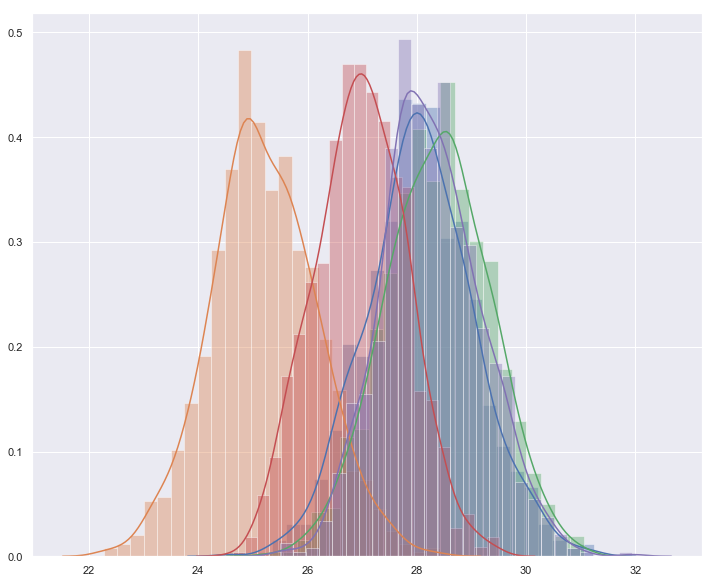

In [72]:
#list of samples
samples=[tmt5_sample, tmt10_sample, tmt15_sample, tmt20_sample, tmt25_sample]

#population mean
mu = control.mean()

#set alpha
alpha = 0.05

for s in samples:
    s = np.array(s)
    one_sample_ttest(s, mu, alpha)

### Closing Thoughts
Well, it appears at every inidividual level of discount, there are statistically significant results indicating that any level of discount between 5% and 25% has a significant effect on the quantity of products ordered. 

### Future Considerations
This is good to know as the business plans for future discounts. Offering discounts could help the business in moving stock, attracting new customers, and reaching sales targets during specific seasons. It is important to note, however, that we need to understand profit margin, gross sales figures, and breakeven points as quantity ordered may not be enough to surpass the revenue that would have been generated by selling a smaller quantity at no discount.

Future experiments could include:
- Forecasting with and without discounts to determine if it is a sound business decision to offer a discount. 
- Understanding purchasing behavior timing and preference; this would help the business to determine when the best time to offer a discount is.
- Determining the relationship between Price and Discount. Perhaps items that are more expensive sell in higher quantities when discounted

## Question 2: Do higher value products sell more when a discount is present?


To do this, I will need to combine several tables: Product and OrderDetail

In [75]:
get_columns_info('OrderDetail')

Table Name: OrderDetail

Name: Id 	 Type: VARCHAR(8000)
Name: OrderId 	 Type: INTEGER
Name: ProductId 	 Type: INTEGER
Name: UnitPrice 	 Type: DECIMAL
Name: Quantity 	 Type: INTEGER
Name: Discount 	 Type: FLOAT


In [109]:
get_columns_info('Product')

2019-05-04 10:57:54,728 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Product")


INFO:sqlalchemy.engine.base.Engine:PRAGMA table_info("Product")


2019-05-04 10:57:54,730 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


Table Name: Product

Name: Id 	 Type: INTEGER
Name: ProductName 	 Type: VARCHAR(8000)
Name: SupplierId 	 Type: INTEGER
Name: CategoryId 	 Type: INTEGER
Name: QuantityPerUnit 	 Type: VARCHAR(8000)
Name: UnitPrice 	 Type: DECIMAL
Name: UnitsInStock 	 Type: INTEGER
Name: UnitsOnOrder 	 Type: INTEGER
Name: ReorderLevel 	 Type: INTEGER
Name: Discontinued 	 Type: INTEGER


In [114]:
#This SQL query selects all rows and columns from my OrderDetail table and puts it into a dataframe. 
q = """SELECT *
       FROM Product p 
       JOIN OrderDetail od on p.Id = od.ProductId
       ORDER BY Discount"""

df2 = pd.read_sql_query(q, engine)
df2.head()

2019-05-04 11:06:06,525 INFO sqlalchemy.engine.base.Engine SELECT *
       FROM Product p 
       JOIN OrderDetail od on p.Id = od.ProductId
       ORDER BY Discount


INFO:sqlalchemy.engine.base.Engine:SELECT *
       FROM Product p 
       JOIN OrderDetail od on p.Id = od.ProductId
       ORDER BY Discount


2019-05-04 11:06:06,527 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,11,Queso Cabrales,5,4,1 kg pkg.,21.00,22,30,30,0,10248/11,10248,11,14.0,12,0.0
1,42,Singaporean Hokkien Fried Mee,20,5,32 - 1 kg pkgs.,14.00,26,0,0,1,10248/42,10248,42,9.8,10,0.0
2,72,Mozzarella di Giovanni,14,4,24 - 200 g pkgs.,34.80,14,0,0,0,10248/72,10248,72,34.8,5,0.0
3,14,Tofu,6,7,40 - 100 g pkgs.,23.25,35,0,0,0,10249/14,10249,14,18.6,9,0.0
4,51,Manjimup Dried Apples,24,7,50 - 300 g pkgs.,53.00,20,0,10,0,10249/51,10249,51,42.4,40,0.0


### Closing Thoughts
It is apparent that ___ does. It is important to note that there are many other factors that affect an employee's revenue. For example, specific territories might bring in more money and a sales person responsible for that territory may not be the sole reason for that. 

### Future Considerations

## Question 3: Which employees and territories bring in the most revenue? 

Next I want to understand which employees bring in the most revenue. This is important because organizations can easily implement training programs geared toward specific subsections of employees. Newer employees don't bring in as much revenue? Create mentorship programs, training programs, and learning development series. More tenured employees don't bring in as much? Create training programs, badge programs, and merit awards.